# Deeply Convolutional Generative Adversarial Network

## Import library

In [1]:
import torch 
import torch.nn as nn
from torch.nn import init
import numpy as np

## Plot

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return 

## Load Data and preprocess

In [4]:
import torchvision
import torchvision.transforms as transform

In [5]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets

## Sampler

In [6]:
from torch.utils.data import sampler

In [7]:
class Sampler(sampler.Sampler):
    def __init__(self, num_samples, start=0):
        self.num_samples = num_samples
        self.start = start
        
    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))
    
    def __len__(self):
        return self.num_samples

In [8]:
def preprocess_img(x):
    x = transform.ToTensor()(x)
    return (x - 0.5) / 0.5

def deprocess_img(x):
    return (x + 1.0) / 2.0

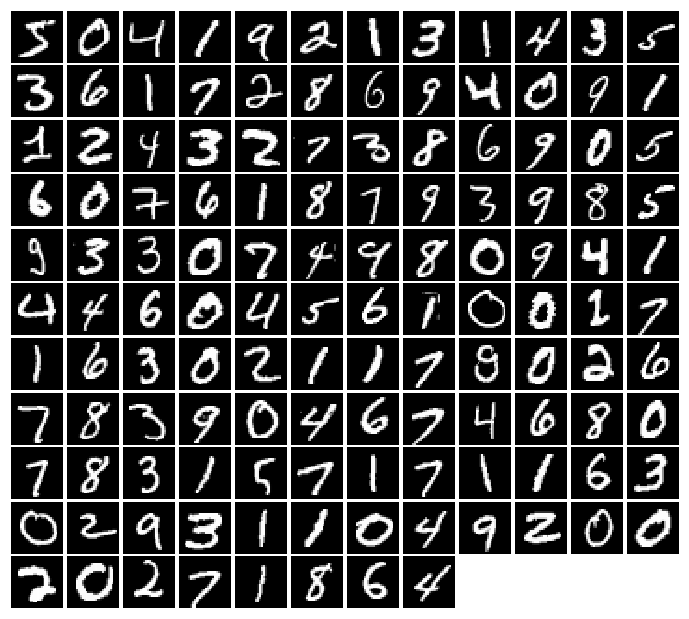

In [9]:
NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

train_set = datasets.MNIST('./data', train=True, download=True, transform=preprocess_img)

train_data = DataLoader(train_set, batch_size=batch_size, sampler=Sampler(NUM_TRAIN, 0))

val_set = datasets.MNIST('./data', train=True, download=True, transform=preprocess_img)

val_data = DataLoader(val_set, batch_size=batch_size, sampler=Sampler(NUM_VAL, NUM_TRAIN))


imgs = deprocess_img(train_data.__iter__().next()[0].view(batch_size, 784)).numpy().squeeze() # visualize images
show_images(imgs)

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Discriminator

In [11]:
class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5, 1),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.01),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x

## Generator

In [12]:
class generator(nn.Module): 
    def __init__(self, noise_dim=NOISE_DIM):
        super(generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(noise_dim, 1024),
            nn.ReLU(True),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 7 * 7 * 128),
            nn.ReLU(True),
            nn.BatchNorm1d(7 * 7 * 128)
        )
        
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 7, 7) # reshape (-1, 128, 7, 7)
        x = self.conv(x)
        return x

## Loss

In [13]:
from torch.autograd import Variable

In [14]:
# bce(s,y)=y∗log(s)+(1−y)∗log(1−s)
bce_loss = nn.BCEWithLogitsLoss()

# ℓD=−𝔼x∼pdata[logD(x)]−𝔼z∼p(z)[log(1−D(G(z)))]
def discriminator_loss(logits_real, logits_fake): # discriminator loss
    size = logits_real.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float()
    false_labels = Variable(torch.zeros(size, 1)).float()
    loss = bce_loss(logits_real, true_labels) + bce_loss(logits_fake, false_labels)
    return loss
# ℓG=−𝔼z∼p(z)[logD(G(z))]
def generator_loss(logits_fake): # generator loss  
    size = logits_fake.shape[0]
    true_labels = Variable(torch.ones(size, 1)).float()
    loss = bce_loss(logits_fake, true_labels)
    return loss

## Optimizer

In [15]:
import torch.optim as optim

In [16]:
def get_optimizer(model):
    """
    Construct and return an Adam optimizer for the model with learning rate 1e-3,
    beta1=0.5, and beta2=0.999.

    Input:
    - model: A PyTorch model that we want to optimize.

    Returns:
    - An Adam optimizer for the model with the desired hyperparameters.
    """
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999))
    return optimizer

## Trainer

In [17]:
def train_dc_gan(D, G_, D_optimizer, G_optimizer, discriminator_loss, generator_loss, show_every=250, 
                noise_size=96, num_epochs=10):
    iter_count = 0
    for epoch in range(num_epochs):
        for x, _ in train_data:
            bs = x.shape[0]
            # Discriminator network
            real_data = Variable(x).to(device) # real images
            logits_real = D(real_data) # discriminate real images
            
            sample_noise = (torch.rand(bs, noise_size) - 0.5) / 0.5 # random sampler
            g_fake_seed = Variable(sample_noise).to(device)
            fake_images = G(g_fake_seed) # generate fake images
            logits_fake = D(fake_images) # Discriminate fake images

            d_total_error = discriminator_loss(logits_real, logits_fake) # discriminator loss
            D_optimizer.zero_grad()
            d_total_error.backward()
            D_optimizer.step() # optimize discriminator
            
            # Generative network
            g_fake_seed = Variable(sample_noise).to(device)
            fake_images = G(g_fake_seed) # generate fake image

            gen_logits_fake = D(fake_images)
            g_error = generator_loss(gen_logits_fake) # generator loss
            G_optimizer.zero_grad()
            g_error.backward()
            G_optimizer.step() # optimize generator

            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count, d_total_error.data.item(), g_error.data.item()))
                imgs_numpy = deprocess_img(fake_images.data.cpu().numpy())
                show_images(imgs_numpy[0:16])
                plt.show()
                print()
            iter_count += 1

## Train

Iter: 0, D: 1.394, G:0.8959


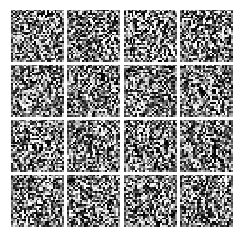

KeyboardInterrupt: 

In [18]:
D = discriminator().to(device)
G = generator().to(device)

D_optim = get_optimizer(D)
G_optim = get_optimizer(G)

train_dc_gan(D, G, D_optim, G_optim, discriminator_loss, generator_loss, num_epochs=5)